In [1]:
 """
 This is an instructional Jupyter notebook that demonstrates 
 how to do basic flows analysis and predict short-term bitcoin
 price movements. 
 
 Here we balance the total flow of bitcoin out of miner wallets,
 after accounting for mining rewards, against the amount of 
 bitcoin being absorbed into cold wallets. The theory is that
 in the long-term these two values should equalize and the
 market should hit a steady-state. Essentially it's a
 measurement of whether bitcoin are becoming easier or harder
 to buy.
 

 Author: T. From Coding Always & Data Always. 
 Twitter: @Data_Always
 
 Last Modified: March 23, 2022
 """

"\nThis is an instructional Jupyter notebook that demonstrates \nhow to do basic flows analysis and predict short-term bitcoin\nprice movements. \n\nHere we balance the total flow of bitcoin out of miner wallets,\nafter accounting for mining rewards, against the amount of \nbitcoin being absorbed into cold wallets. The theory is that\nin the long-term these two values should equalize and the\nmarket should hit a steady-state. Essentially it's a\nmeasurement of whether bitcoin are becoming easier or harder\nto buy.\n\n\nAuthor: T. From Coding Always & Data Always. \nTwitter: @Data_Always\n\nLast Modified: March 23, 2022\n"

In [2]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Import some common libraries

from coinmetrics.api_client import CoinMetricsClient
# https://coinmetrics.github.io/api-client-python/site/index.html


def set_plt_defaults():
    plt.rcParams['figure.figsize'] = (14, 8)
    # Default figure size.

    plt.rcParams['figure.subplot.left'] = 0.05
    plt.rcParams['figure.subplot.top'] = 0.92
    plt.rcParams['figure.subplot.right'] = 0.95
    plt.rcParams['figure.subplot.bottom'] = 0.08
    # Position the chart in the figure
        
    fig_out = plt.figure()
    ax_out = plt.subplot2grid((1,1), (0,0))
    # Assign the outputs to return.
            
    plt.grid(color=[0.25]*3, 
             linestyle='-', 
             linewidth=0.75, 
             alpha=0.25, 
             zorder=0
            )
    # Gridline styling

    ax_out.xaxis.grid()
    # Only plot horizontal gridlines.

    return fig_out, ax_out;

In [3]:
client = CoinMetricsClient()
# Initialize an API client 

In [4]:
start_date = '2016-01-01'
# Earliest date of data to download

# First download bitcoin price data, followed by the rest of the metrics we need
btc_data = client.get_asset_metrics(
    assets=['btc'],
    metrics=['ReferenceRate'],
    start_time=f'{start_date}T00:00:00Z',
    frequency='1d'
)
df = btc_data.to_dataframe()

df = df.rename(columns={'ReferenceRate':'btc-usd'})
# Rename the price column 

df.drop(columns=['asset'], axis=1, inplace=True)
# Drop unwanted columns


In [5]:
# Define the metrics we want to download and how we want to rename them
endpoints = {'SplyMiner0HopAllNtv' : 'miner-supply',
             'FlowInExNtv' : 'exchange-inflows',
             'FlowOutExNtv' : 'exchange-outflows',
             'IssTotNtv' : 'new-issuance',
             'FeeTotNtv' : 'transaction-fees'
            }

# Download the rest of the desired metrics
data = client.get_asset_metrics(
    assets=['btc'],
    metrics=list(endpoints.keys()),
    start_time=f'{start_date}T00:00:00Z',
    frequency='1d'
)

cm_df = data.to_dataframe()
# Throw the data in a dataframe

In [6]:
# Merge, sort, re-index, and rename the dataframes

tmp_df = cm_df[['time'] + list(endpoints.keys())]
# Keep only the desired columns

df = df.merge(tmp_df, on="time", how="outer")
# Merge the dataframes

df = df.sort_values(by="time")
df = df.set_index(pd.DatetimeIndex(df['time']))
# Sort and re-index the columns

df = df.rename(columns=endpoints)
# Rename columns

#df = df[:-1]
# Data seems to usually be one ahead on something (probably price)

In [7]:
# Clean null values b/c of CoinMetrics data structuring
df['new-issuance'] = df['new-issuance'].replace('None', '0').astype(float)
df['transaction-fees'] = df['transaction-fees'].replace('None', '0').astype(float)

In [8]:
# Calculate custom metrics for flows analysis

df['supply-inflow'] = df['new-issuance'] + df['transaction-fees'] - df['miner-supply'].diff()
# The net bitcoin flowing out of miner wallets after accounting for mining rewards

df['absorbed-supply'] = df['new-issuance'] + (df['exchange-outflows'] - df['exchange-inflows']) - df['miner-supply'].diff()
# The change in total supply outside of exchange and miner wallets (ie: flow into individual wallets)

df['flows-fair-value'] = df['absorbed-supply']/df['supply-inflow']
# Quotient of the two metrics to measure how balanced the flow dynamics are

df = df[2:]
# Drop the first row because of the diff calculations

In [9]:
# All the metrics don't necessarily get updated at the same time,
# so sometimes you'll need to drop the last, or the last two
# datapoints of the series. 

to_drop = df['flows-fair-value'].isna().sum()
df = df[:-to_drop]


In [10]:
df.tail()

,time,btc-usd,miner-supply,exchange-inflows,exchange-outflows,new-issuance,transaction-fees,supply-inflow,absorbed-supply,flows-fair-value
time,,,,,,,,,,
2022-03-18 00:00:00+00:00,2022-03-18 00:00:00+00:00,40966.416932,1799697.12233,31308.57674,32620.998975,893.75,11.000626,939.077687,2240.499297,2.385851
2022-03-19 00:00:00+00:00,2022-03-19 00:00:00+00:00,41826.116071,1799825.394159,14128.260917,16710.978151,968.75,7.647999,848.126171,3423.195406,4.036187
2022-03-20 00:00:00+00:00,2022-03-20 00:00:00+00:00,42193.161536,1799731.324441,8708.460804,64201.366985,962.50,6.420094,1062.989811,56549.475898,53.198512
2022-03-21 00:00:00+00:00,2022-03-21 00:00:00+00:00,41294.723513,1799697.960023,21543.727456,87222.144839,956.25,9.557095,999.171514,66668.031802,66.723311
2022-03-22 00:00:00+00:00,2022-03-22 00:00:00+00:00,41064.429648,1799719.149042,29738.531626,36092.553159,931.25,10.769047,920.830028,7264.082513,7.888625


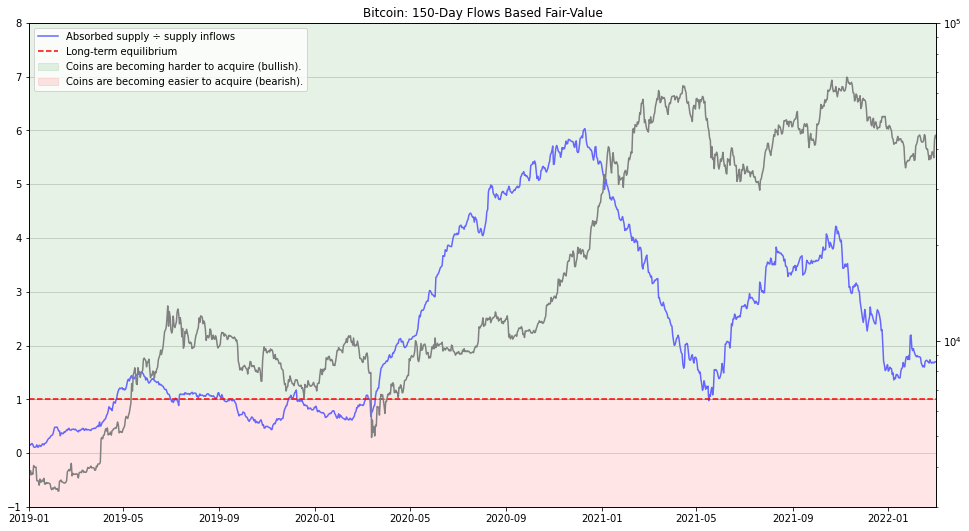

In [11]:
# This is a very basic plot of a flows model for short-term price changes

ws = 150
# Window size of flows data to look at (usually 90-180 days)

fig, ax1 = set_plt_defaults()
plt.title(f'Bitcoin: {ws}-Day Flows Based Fair-Value')
# Basic plot setup

ax1.plot(df['time'], list(df['flows-fair-value'].rolling(ws).mean()), alpha=1, color=[0.4, 0.4, 1], label='Absorbed supply ÷ supply inflows')
# Plot the quotient of the two values (150 day average)

ax1.axhline(y=1, color='r', ls='--', label='Long-term equilibrium')
# Plot the long-term equilibrium line

ax1.set_ylim([-1, 8])
# Set the plot boundaries

ax1.axhspan(ymin=1, ymax=ax1.get_ylim()[1], color='g', alpha=0.10, label='Coins are becoming harder to acquire (bullish).')
ax1.axhspan(ymin=ax1.get_ylim()[0], ymax=1, color='r', alpha=0.10, label='Coins are becoming easier to acquire (bearish).')
# Lightly color the bearish/bullish regions 

ax1.legend(loc='upper left')
# Create a legend for the plot

# Create a twin of the x-axis to plot the price alongside the flows data
ax2 = ax1.twinx()
ax2.plot(df['time'], list(df['btc-usd']), color=[0.5]*3)
# Plot the price of bitcoin in gray

ax2.set_yscale('log')
# Use a log-scale for the price of bitcoin

ax2.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2022-03-03')])
ax2.set_ylim([3000, 100000])
# Set the plot limits

plt.savefig('./demo-bitcoin-flows-analysis.png', transparent=False, facecolor='white')
plt.show()